# Code setup

In [1]:
try:
    %load_ext lab_black
except ModuleNotFoundError:
    print("Couldn't load Black autoformatter.")

In [2]:
# To suppress warning output
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# Important imports
import numpy as np
from numpy import random
import pandas as pd
import os, sys
import math

# Set random seed across notebook for repeatable results
np.random.seed(1922)  # for Papa

In [19]:
# To plot nice figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib.cm as cm

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.titlesize"] = "x-large"  # 16
plt.rcParams["axes.labelsize"] = "x-large"
plt.rcParams["xtick.labelsize"] = "x-large"
plt.rcParams["ytick.labelsize"] = "x-large"

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "figs"

if not (os.path.isdir(PROJECT_ROOT_DIR + "/" + PROJECT_SAVE_DIR)):
    print("Figure directory did not exist, creating now.")
    os.mkdir(PROJECT_ROOT_DIR + "/" + PROJECT_SAVE_DIR)
else:
    print("Figure directory exists.")

Figure directory exists.


In [5]:
# Import classes and functions used across multiple notebooks
sys.path.append(os.getcwd())
import importlib
import functions as blt

importlib.reload(blt)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
Figure directory exists.
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
Figure directory exists.


<module 'functions' from '/app/src/functions.py'>

In [6]:
from notebook.services.config import ConfigManager

ConfigManager().update(
    "notebook",
    {
        "ExecuteTime": {
            "display_absolute_timestamps": False,
            "relative_timing_update_period": 5,
            "template": {
                "executed": "started ${start_time}, finished in ${duration}",
            },
        }
    },
)

{'ExecuteTime': {'display_absolute_timestamps': False,
  'relative_timing_update_period': 5,
  'template': {'executed': 'started ${start_time}, finished in ${duration}'}}}

# Data

In [34]:
# Source (bulk organics) data

# Read in organics CP feature data
X = pd.read_csv(
    "./data/organics-preprocessed-feats.csv", sep="\t", header="infer", index_col=0
)
# Read in organics CP labels (maximum_weight_fraction)
y = pd.read_csv(
    "./data/organics-preprocessed-WF.csv", sep="\t", header="infer", index_col=0
)
y.index = X.index
print("X shape:", X.shape)
print("y shape:", y.shape)

# Read in previous hyperparameterization results
results_prelim = pd.read_csv(
    "./data/results-prelim-organics.csv", sep="\t", na_values="nan"
)

X shape: (16439, 53)
y shape: (16439, 1)


## Apply WF bins

Labels (continuous WF data) will be binned into low (0.00-0.01), medium (0.01-0.10) and high (0.10-1.00) categories.

In [9]:
# Apply bins to organics data
ybin = np.asarray(y.apply(blt.bins, axis=1))

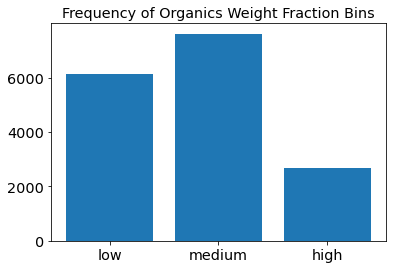

Label bin:  [0 1 2]
Count    :  [6127 7617 2695]
Frequency:  [0.37, 0.46, 0.16]


In [14]:
# View bar plot of WF bins
blt.bar_graph_bins(ybin, data_composition="Organics")

## Split data

In [15]:
# Split training data into training and test data (to be set aside)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, ybin, test_size=4110, random_state=1922, stratify=ybin
)
print([X_train.shape, X_test.shape])
print([y_train.shape, y_test.shape])

[(12329, 53), (4110, 53)]
[(12329,), (4110,)]


In [16]:
# Set aside "source" data
from sklearn.model_selection import train_test_split

X_train, X_source, y_train, y_source = train_test_split(
    X_train, y_train, train_size=100, random_state=1922, stratify=y_train
)
print([X_train.shape, X_source.shape])
print([y_train.shape, y_source.shape])

[(100, 53), (12229, 53)]
[(100,), (12229,)]


## Pre-check PCA

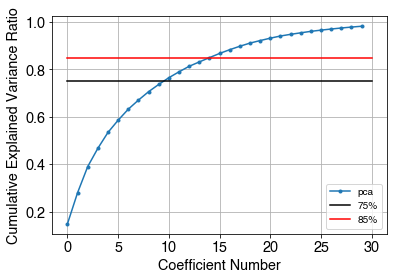

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition

# Scale the data first (i.e., chemical properties) from 0 to 1
scaler = MinMaxScaler()
X_source_scaled = scaler.fit_transform(X_source)

# Figure out number of components to achieve 85% cumulative explained variance
pca = decomposition.PCA(n_components=30)
pca.fit(X_source_scaled)

fig = plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), ".-", label="pca")
plt.plot([0, 30], [0.75, 0.75], "k", label="75%")
plt.plot([0, 30], [0.85, 0.85], "r", label="85%")
plt.xlabel("Coefficient Number")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.grid()
plt.legend()
plt.show()

# Model optimization

In [20]:
import random as pyrandom
from numpy import random
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import MinMaxScaler

# Define feature mask for data augmentation
feat_names = X_source.columns
col_mask = ["cprp" not in name for name in feat_names]


# Function to add samples to training data


def random_augment(k, X_source, y_source, random_state, X, y):
    """Randomly samples source data to pair with target data."""

    if k == 0:
        return X, y

    pyrandom.seed(random_state)
    np.random.seed(random_state)

    # Number of samples to select
    n_samples = k * len(X)
    # Obtain indices for randomly sampling source data
    idx_match = np.random.choice(len(X_source), n_samples)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match, :]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))
    assert (
        X_aug.shape[0] == y_aug.shape[0]
    ), f"X_aug.shape={X_aug.shape}, y_aug.shape={y_aug.shape}"

    return X_aug, y_aug


def unsupervised_augment(k, X_source, y_source, random_state, X, y):
    """
    Unsupervised data augmentation

    Match "k" most similar source data samples to target data samples
    based on the smallest cosine distance between target and source data
    samples (i.e., in an supervised fashion).
    """

    if k == 0:
        return X, y

    pyrandom.seed(random_state)
    np.random.seed(random_state)

    # Cosine distance matrix using feature mask
    cosdist_samples = cosine_distances(X_source * col_mask, X * col_mask)
    # Loop over distance matrix in search of k-smallest distances
    idx_match = []
    for col in cosdist_samples.T:
        # Find organics data indices of k-smallest distances
        matches = np.argpartition(col, k)[:k]
        idx_match.extend(matches)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match, :]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))

    return X_aug, y_aug

In [21]:
# Define models and parameters
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt

random_state = 1922
augmentation_kwargs = {
    "augmentation_random_state": random_state,
    "augmentation_X_source": X_source,
    "augmentation_y_source": y_source,
}

models = {
    "RandomForestClassifier": blt.AugmentingPipeline(
        [
            ("scaler", MinMaxScaler()),  # normalization from 0 to 1
            ("dimreducer", PCA()),
            (
                "estimator",
                RandomForestClassifier(
                    class_weight="balanced", random_state=random_state
                ),
            ),
        ],
        **augmentation_kwargs
    ),
    "SVC": blt.AugmentingPipeline(
        [
            ("scaler", MinMaxScaler()),  # normalization from 0 to 1
            ("dimreducer", PCA()),
            (
                "estimator",
                SVC(
                    kernel="rbf",
                    class_weight="balanced",  # balance by class size
                    random_state=random_state,
                ),
            ),
        ],
        **augmentation_kwargs
    ),
}
params = {
    "RandomForestClassifier": {
        "augmentation_type": [random_augment],
        "augmentation_k": [0, 1, 2, 3, 4, 9, 19, 29, 39, 49, 99],
        "dimreducer__n_components": [10, 11, 12, 13, 14],
        "estimator__max_depth": np.arange(2, 15, 2),
    },
    "SVC": {
        "augmentation_type": [random_augment],
        "augmentation_k": [0, 1, 2, 3, 4, 9, 19],
        "dimreducer__n_components": [10, 11, 12, 13, 14],
        "estimator__C": np.logspace(-1, 7, 9),
        "estimator__gamma": np.logspace(-7, 1, 9),
    },
}

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score

# Apply gridsearch for optimal parameters
helper = blt.EstimatorSelectionHelper(models, params)
helper.fit(
    X_train, y_train, n_jobs=1, cv=5, scoring="balanced_accuracy",
)
results_prelim = helper.score_summary(sort_by="mean_score")
results_prelim.columns = [col.split("__")[-1] for col in results.columns]
results_prelim.infer_objects()

Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 385 candidates, totalling 1925 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1925 out of 1925 | elapsed:  8.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


[Parallel(n_jobs=1)]: Done 16200 out of 16200 | elapsed: 294.6min finished


RandomForestClassifier
SVC


,estimator,min_score,mean_score,max_score,std_score,augmentation_k,augmentation_type,n_components,max_depth,C,gamma
256,RandomForestClassifier,0.457672,0.707593,0.841270,0.133323,20,<function random_augment at 0x112173f80>,11,10.0,NaN,NaN
3288,SVC,0.477513,0.702751,0.888889,0.140596,20,<function random_augment at 0x112173f80>,10,NaN,1000000.0,1.000000e-02
263,RandomForestClassifier,0.457672,0.697328,0.804762,0.126307,20,<function random_augment at 0x112173f80>,12,10.0,NaN,NaN
272,RandomForestClassifier,0.505291,0.697328,0.804762,0.102279,20,<function random_augment at 0x112173f80>,13,14.0,NaN,NaN
248,RandomForestClassifier,0.531746,0.693968,0.841270,0.123206,20,<function random_augment at 0x112173f80>,10,8.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3563,SVC,0.333333,0.333333,0.333333,0.000000,20,<function random_augment at 0x112173f80>,14,NaN,10.0,1.000000e-06
3564,SVC,0.333333,0.333333,0.333333,0.000000,20,<function random_augment at 0x112173f80>,14,NaN,10.0,1.000000e-05
3571,SVC,0.333333,0.333333,0.333333,0.000000,20,<function random_augment at 0x112173f80>,14,NaN,100.0,1.000000e-07
3572,SVC,0.333333,0.333333,0.333333,0.000000,20,<function random_augment at 0x112173f80>,14,NaN,100.0,1.000000e-06


In [18]:
# %run organicstrain.py
# results_prelim = blt.apply_model_opt(models, params, X_target=X_train, y_target=y_train, cust_folds=5, random_state=1922, n_jobs=2,)

In [17]:
# Export preliminary results table to .csv
results_prelim.to_csv(
    "./data/results-prelim-organics.csv",
    sep="\t",
    header="infer",
    na_rep="NaN",
    index=False,
)

In [35]:
results_prelim[results_prelim["augmentation_k"] == 99]

,estimator,min_score,mean_score,max_score,std_score,augmentation_k,augmentation_type,n_components,max_depth,C,gamma


# Model evaluation

## SVC-RBF

In [46]:
def eval_blindtest(
    df_params, random_state=1922, X=X_train, y=y_train, show_conf_matrix=True,
):
    """
    Apply hyperparameters for model evaluation.
    """

    from sklearn.decomposition import PCA
    from sklearn.metrics import confusion_matrix

    X = np.array(X)
    n_b = len(np.unique(y))  # Check number of bins

    # Select for highest performing parameters (averaged across 5 folds);
    # note that these are sorted by best mean score
    df_params["augmentation_type"] = [
        str(i).split(" ")[1] for i in df_params.loc[:, "augmentation_type"]
    ]
    feat_subset = ["estimator", "augmentation_k", "augmentation_type"]
    df_params = df_params.drop_duplicates(subset=feat_subset, keep="first")
    df_params = df_params.sort_values(by=feat_subset, ascending=[False, True, True])
    df_params.columns = [col.split("__")[-1] for col in df_params.columns]
    df_params = df_params.reset_index(drop=True)

    # Placeholder list for output
    df_params["score"] = np.nan
    df_params["score"] = df_params["score"].astype(object)

    for row in df_params.index:
        # Dictionary of classifier parameters, dropping nans
        cls_kwargs = df_params.iloc[row, -4:-1].dropna().to_dict()
        print(cls_kwargs)
        # Classifier function using dict
        if df_params.loc[row, "estimator"] == "SVC":
            classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
        else:
            classifier = RandomForestClassifier(class_weight="balanced", **cls_kwargs)
        # Define feature reducer
        pca = PCA(n_components=df_params.n_components[row], copy=True)
        # Make sure augmentation_type is a function
        augmentation_type = df_params.augmentation_type[row]
        dispatcher = {
            "random_augment": random_augment,
        }
        if isinstance(augmentation_type, str):
            augmentation_type = dispatcher[augmentation_type]
        # Name figures using concatenated strings
        save_fig_name = "_".join(map(str, list(df_params.loc[row, feat_subset])))

        # Make parameter dicts
        augmentation_kwargs = {
            "augmentation_X_source": X_source,
            "augmentation_y_source": y_source,
            "augmentation_type": augmentation_type,
            "augmentation_k": df_params.augmentation_k[row],
        }

        # Pipeline with data augmentation
        pipe = blt.AugmentingPipeline(
            [
                ("scaler", MinMaxScaler()),
                ("dimreducer", pca),
                ("estimator", classifier.set_params(random_state=random_state)),
            ],
            **augmentation_kwargs
        )
        pipe.fit(X, y)

        # Write prediction results to confusion matrix
        conf_matrix = np.zeros([n_b, n_b])
        conf_matrix = confusion_matrix(y_test, pipe.predict(X_test), normalize="true")

        # Plot normalized confusion matrix
        fig = plt.figure()
        blt.plot_conf_matrix(conf_matrix, classes=["low", "mid", "high"])
        if not show_conf_matrix:
            plt.close(fig)

        # Get balanced average proportion of correct classifications
        df_params.score[row] = conf_matrix.diagonal().mean()

    cols_report = ["estimator", "augmentation_type", "augmentation_k", "score"]

    return df_params[cols_report]

{'C': 1000000.0, 'gamma': 0.001}
{'C': 10000.0, 'gamma': 0.1}
{'C': 1000000.0, 'gamma': 1.0}
{'C': 10000.0, 'gamma': 1e-06}
{'C': 10000000.0, 'gamma': 1e-05}
{'C': 10000000.0, 'gamma': 1e-07}
{'C': 100000.0, 'gamma': 0.01}
{'C': 1000000.0, 'gamma': 0.01}


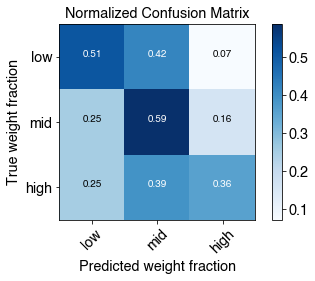

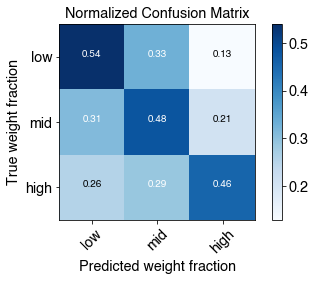

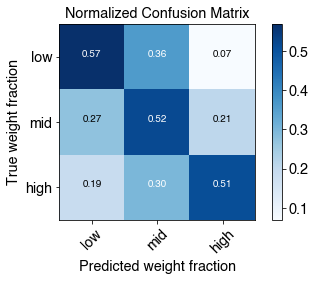

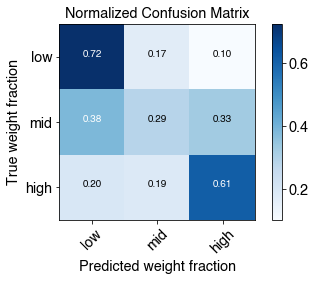

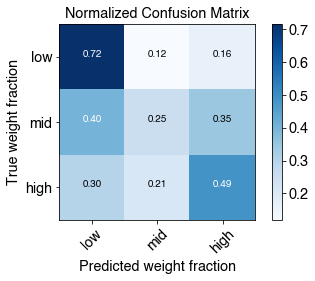

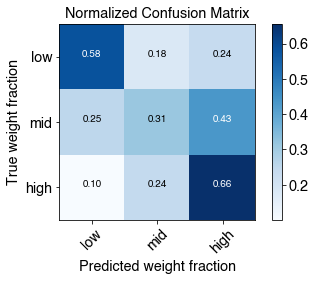

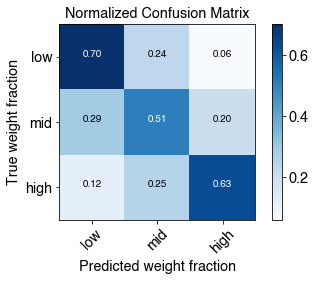

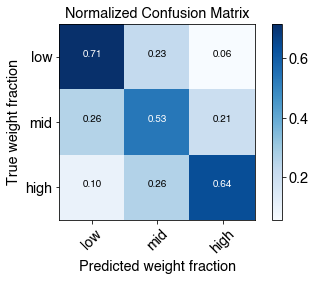

In [47]:
# SVC
results_svc = eval_blindtest(
    results_prelim[results_prelim["estimator"] == "SVC"].astype(object)
)

## RFC

{'max_depth': 6.0}
{'max_depth': 4.0}
{'max_depth': 2.0}
{'max_depth': 8.0}
{'max_depth': 4.0}
{'max_depth': 4.0}
{'max_depth': 6.0}
{'max_depth': 10.0}
{'max_depth': 8.0}
{'max_depth': 14.0}
{'max_depth': 10.0}


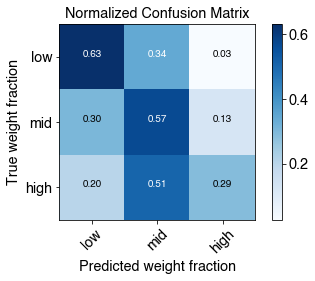

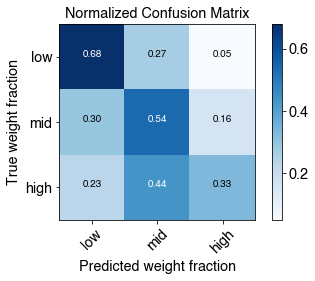

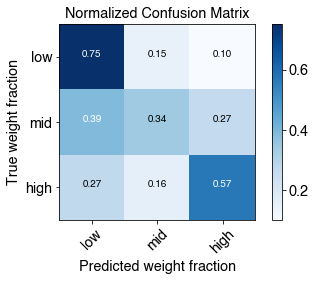

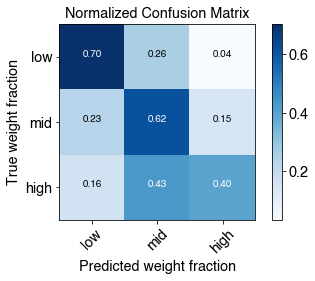

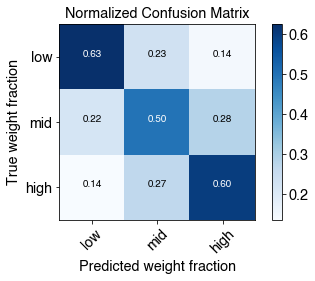

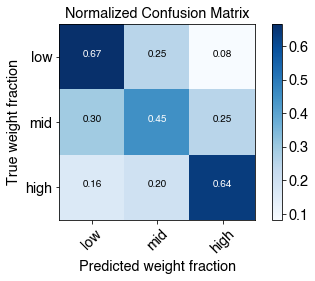

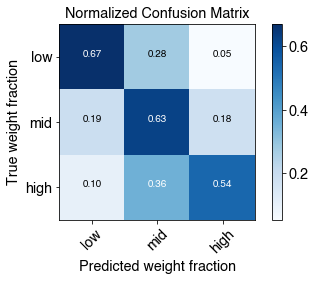

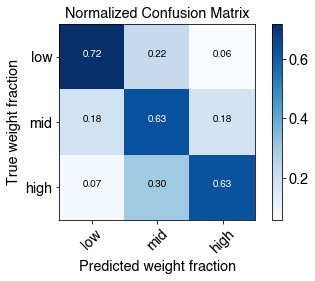

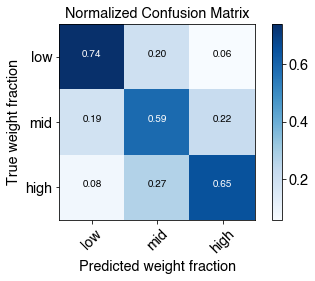

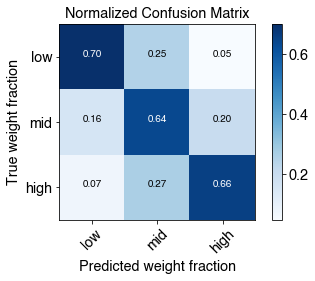

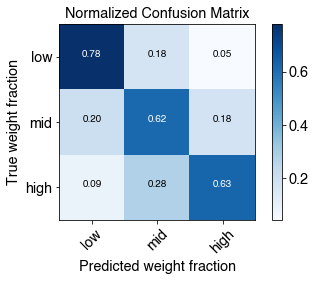

In [48]:
# RFC
results_rfc = eval_blindtest(
    results_prelim[results_prelim["estimator"] == "RandomForestClassifier"]
)

# Performance results

Note that data augmentation was not performed on data frames only containing ENM data (non-permuted and permuted).

In [127]:
def display_table(df, df2=None):
    """Redisplay results as table for publication."""

    if isinstance(df2, pd.DataFrame):
        df = pd.concat([df, df2])

    # Tidy up labels, decimal places
    df.rename(columns={"augmentation_k": "k"}, inplace=True)
    df["estimator"] = df["estimator"].str.replace("RandomForestClassifier", "RFC")
    pd.set_option("display.precision", 3)

    # Include column for number of training samples
    n = X_train.shape[0]
    df["training samples"] = df["k"] * n + n

    # Pivot table
    table = df.pivot(index=["training samples"], columns="estimator", values="score",)

    return table

In [128]:
results_final_organics = display_table(results_svc, results_rfc)
results_final_organics

estimator,RFC,SVC
training samples,,
100,0.497,0.485
200,0.518,0.492
300,0.554,0.533
400,0.576,0.541
500,0.574,0.485
600,0.584,0.518
1100,0.613,0.615
2100,0.66,0.629
3100,0.659,NaN


In [129]:
def line_plot(df, save_fig_name=None):

    myplot = df["RFC"].plot(kind="line", color="navy", marker="^")
    df["SVC"].plot(kind="line", color="royalblue", marker="o")
    plt.title("Performance of Classification Models", pad=10)
    plt.xlabel("Number of Training Samples")
    plt.ylabel("Average Balanced Accuracy")
    plt.gca().legend(loc="right", ncol=1)
    plt.xscale("log")
    if save_fig_name:
        fig = myplot.get_figure()
        blt.savepdf(fig, save_fig_name)

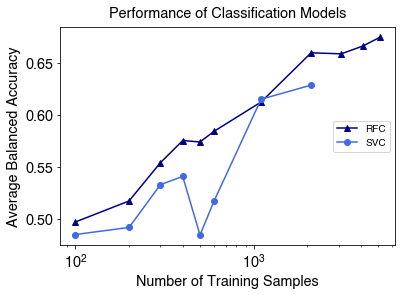

In [130]:
line_plot(df=results_final_organics, save_fig_name="bal-accu-plot-organics")

In [131]:
# Export results table as a LaTeX-compatible file
results_final_organics.to_latex()

'\\begin{tabular}{lll}\n\\toprule\nestimator &    RFC &    SVC \\\\\ntraining samples &        &        \\\\\n\\midrule\n100              &  0.497 &  0.485 \\\\\n200              &  0.518 &  0.492 \\\\\n300              &  0.554 &  0.533 \\\\\n400              &  0.576 &  0.541 \\\\\n500              &  0.574 &  0.485 \\\\\n600              &  0.584 &  0.518 \\\\\n1100             &  0.613 &  0.615 \\\\\n2100             &   0.66 &  0.629 \\\\\n3100             &  0.659 &    NaN \\\\\n4100             &  0.666 &    NaN \\\\\n5100             &  0.675 &    NaN \\\\\n\\bottomrule\n\\end{tabular}\n'